In [1]:
import numpy as np
import math
from sympy.parsing.sympy_parser import parse_expr
from sympy import *
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.quantum_info import Pauli
import random as rd
import re
import operator
import functools
from scipy.linalg import expm, sinm, cosm
from numpy.linalg import matrix_power
from typing import Sequence, Tuple
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit

2023-02-03 17:47:04.740306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 17:47:04.740320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03 17:47:06.024647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-03 17:47:06.024662: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 17:47:06.024672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rafael-ThinkPad): /proc/driver/nvidia/version does not exist
2023-02-03 17:47:06.024827: I tensorflow/core/platform/cpu_fe

In [3]:
with open('3sat.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)

c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


In [4]:
class Verifier():
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [5]:
# Function to create the
# random binary string
def rand_key(p):
   
    # Variable to store the
    # string
    key1 = ""
 
    # Loop to find the string
    # of desired length
    for i in range(p):
         
        # randint function to generate
        # 0, 1 randomly and converting
        # the result into str
        temp = str(rd.randint(0, 1))
 
        # Concatenation the random 0, 1
        # to the final result
        key1 += temp
         
    return(key1)

In [6]:
v = Verifier('3sat.dimacs')   

In [7]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(3)

In [8]:
binary_strings

['000', '001', '010', '011', '100', '101', '110', '111']

In [9]:
v.is_correct(binary_strings[0])

True

In [10]:
valid_keys = []

for key in binary_strings:
    if v.is_correct(key) == True:
        print(key) 
        valid_keys.append(key)

000
011
101


## Write clauses symbolically

In [11]:
statement = []
for line in dimacs.split('\n'):
    line = line.strip(' 0')
    clause = []
    for literal in line.split(' '):
            if literal in ['p', 'c']:
            # line is not a clause
                break
            else:
                #print(literal)
                clause.append(int(literal))
    statement.append(clause)

In [12]:
new_stat = [ele for ele in statement if ele != []]

In [13]:
Z = IndexedBase('Z')
i= symbols('i', cls=Idx)

In [14]:
all_clauses = []
for i in range(len(new_stat)):
    clauses_z = []
    for literal in new_stat[i]:
        #print(literal)
        if literal < 0:
            literal_exp = 1 - Z[abs(literal)]
        else:
            literal_exp = 1 + Z[abs(literal)]
        clauses_z.append(literal_exp)
    all_clauses.append(clauses_z)

In [15]:
clauses_list = []
for clause in all_clauses:
    print(expand(np.prod(clause)))
    clauses_list.append(expand(np.prod(clause)))

-Z[1]*Z[2]*Z[3] + Z[1]*Z[2] + Z[1]*Z[3] - Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 1
-Z[1]*Z[2]*Z[3] - Z[1]*Z[2] + Z[1]*Z[3] + Z[1] - Z[2]*Z[3] - Z[2] + Z[3] + 1
-Z[1]*Z[2]*Z[3] + Z[1]*Z[2] - Z[1]*Z[3] + Z[1] - Z[2]*Z[3] + Z[2] - Z[3] + 1
Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] + Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 1
-Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] - Z[1] + Z[2]*Z[3] + Z[2] + Z[3] + 1


In [16]:
total_clause = np.sum(clauses_list)
total_clause

-3*Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] + Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 5

In [17]:
def clause_transformer(clause):

    crcs = []

    for elem in Add.make_args(total_clause):
        el = str(elem)

        if '-' in el and el[1] != 'Z':
            #print(el, -int(el[1]), re.findall(r"\[(\d+)\]", el))
            bit_string = re.findall(r"\[(\d+)\]", el)
            new_bits = [eval(i) for i in bit_string]
            crcs.append((-int(el[1]), [x - 1 for x in new_bits]))

        elif '-' in el and el[1] == 'Z':
            #print(el, -1, re.findall(r"\[(\d+)\]", el))
            bit_string = re.findall(r"\[(\d+)\]", el)
            new_bits = [eval(i) for i in bit_string]
            crcs.append((-1, [x - 1 for x in new_bits]))

        elif 'Z' in el:
            #print(el, +1, re.findall(r"\[(\d+)\]", el))
            bit_string = re.findall(r"\[(\d+)\]", el)
            new_bits = [eval(i) for i in bit_string]
            crcs.append((+1, [x - 1 for x in new_bits]))
        
        else:
            crcs.append(int(el))
          
    return crcs

In [18]:
clause_transformer(total_clause)

[5,
 (-1, [1]),
 (-1, [2]),
 (1, [1, 2]),
 (-1, [0, 1]),
 (-1, [0, 2]),
 (-3, [0, 1, 2]),
 (1, [0])]

In [19]:
gs_energy = -clause_transformer(total_clause)[0]
gs_energy

-5

## Cirq build

In [20]:
qubits = []
nqubits = 3
for i in range(nqubits):
        qubits.append(cirq.GridQubit(0,i))        
qubits = list(reversed(qubits))

In [21]:
all_qubits = [i for i in range(nqubits)]

In [22]:
def z_string_gates(z_inds, par):
    z_string = []
    cnot_gates = []
    #print(z_inds)
    pairs = list(zip([z_inds[0] for i in range(len(z_inds))], z_inds[1:]))
    #print(pairs)
    for pair in pairs:
        #print(pair)
        cnot_gates.append(cirq.CNOT(qubits[pair[1]], qubits[pair[0]]))
    z_string.append(cnot_gates)
    z_string.append(cirq.rz(par).on(qubits[pair[0]]))
    z_string.append(cnot_gates[len(cnot_gates) - 1::-1])
    return z_string

In [23]:
def hamiltonian_circuit(circuit, qubits, par, clause): 
    for elem in clause_transformer(clause):
        res = type(elem) is tuple  
        if res == False:
            for qubit in qubits:
                pass
                #circuit.append(cirq.I(qubit))
        else:
            coef = elem[0]
            z_inds = elem[1]
            #print(sign)
            if len(z_inds) == 1:
                #print(sign, z_inds)
                circuit.append(cirq.rz(coef*par).on(qubits[z_inds[0]]))
            else:
                #print(sign, z_inds)
                circuit.append(z_string_gates(z_inds,coef*par))
    return circuit

In [24]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [25]:
qaoa_circuit = cirq.Circuit()
p = 3

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

for i in range(p):
    qaoa_circuit = hamiltonian_circuit(qaoa_circuit, qubits, parameters[2 * i], total_clause)
    qaoa_circuit = mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

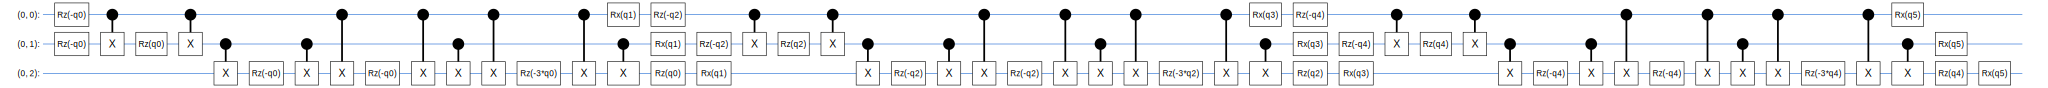

In [26]:
SVGCircuit(qaoa_circuit)

In [27]:
def cost_hamiltonian(qubits, clause):
    h = 0
    for elem in clause_transformer(clause):
        res = type(elem) is tuple  
        if res == False:
            for qubit in qubits:
                pass
                #circuit.append(cirq.I(qubit))
        else:
            coef = elem[0]
            z_inds = elem[1]
            h += coef*math.prod([cirq.Z(qubits[i]) for i in z_inds])
    return h

In [28]:
cost = cost_hamiltonian(qubits, total_clause)

## Optimizing the circuit

In [29]:
initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit))

inputs = tfq.convert_to_tensor([initial])

In [30]:
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost, differentiator = tfq.differentiators.Adjoint())(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)

In [31]:
losses = []
n_epoch = 1000

for epoch in range(n_epoch):
    
    with tf.GradientTape() as tape:
        error = ksat(inputs)
    
    grads = tape.gradient(error, ksat.trainable_variables)
    opt.apply_gradients(zip(grads, ksat.trainable_variables))
    error = error.numpy()[0][0]
    losses.append(error)
    
    print('Loss at epoch ' + str(epoch) + ' is ' + str(error/gs_energy), end = '\r')

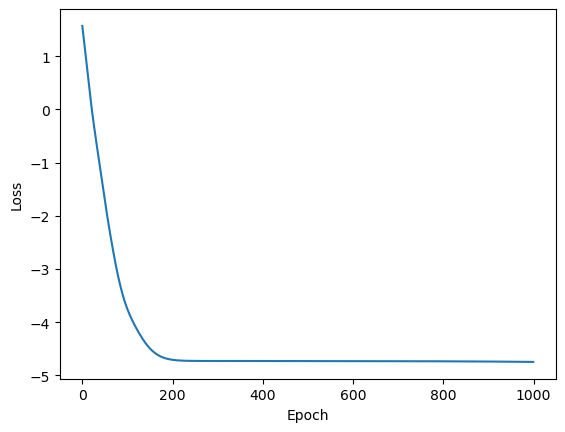

In [32]:
plt.plot(losses)
#plt.title("QAOA with TFQ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#plt.savefig("TSP_losses")

In [33]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

In [34]:
params = ksat.trainable_variables
print(params)

sample_circuit = tfq.layers.AddCircuit()(inputs, append=qaoa_circuit)
output = tfq.layers.Sample()(sample_circuit, symbol_names=parameters, symbol_values=params, repetitions = 1000)

quantum_preds = []
data = []
for bits in output.values:
    temp = []
    data.append(to_dec(bits.numpy()))
    for pos, bit in enumerate(bits):
        if bit == 1:
            temp.append(pos)
    quantum_preds.append(temp)

[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=
array([4.5975013, 0.418594 , 6.5953813, 4.542812 , 1.0443175, 7.1558986],
      dtype=float32)>]


In [35]:
valid_keys

['000', '011', '101']

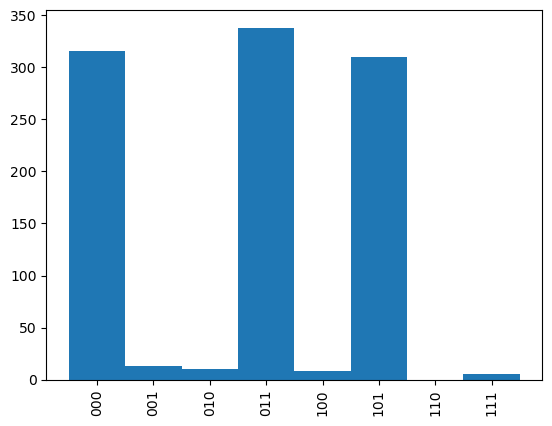

In [36]:
xticks = range(0, 2**nqubits)
xtick_labels = list(map(lambda x: format(x, "0"+str(nqubits)+"b"), xticks))
bins = np.arange(0, 2**nqubits + 1) - 0.5
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(data, bins=bins)
plt.show()